In [84]:
import os
import random
import cv2 as cv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from IPython import get_ipython
import nbformat
import subprocess
from statistics import mean, stdev
from collections import defaultdict

In [77]:
TRAIN_DIR = 'D:/11 semester/CVPR/CIFAR-10-images-master/test'
CATEGORIES = [c for c in os.listdir(TRAIN_DIR)]
print(CATEGORIES)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [78]:
TRAIN_DATA = []
for class_num, category in enumerate(CATEGORIES):
    path = os.path.join(TRAIN_DIR, category)
    for img in tqdm(os.listdir(path)):
        img_arr = cv.imread(os.path.join(path, img))
        TRAIN_DATA.append([img_arr, class_num])

print(len(TRAIN_DATA))

100%|██████████| 1000/1000 [00:00<00:00, 18865.64it/s]

10000


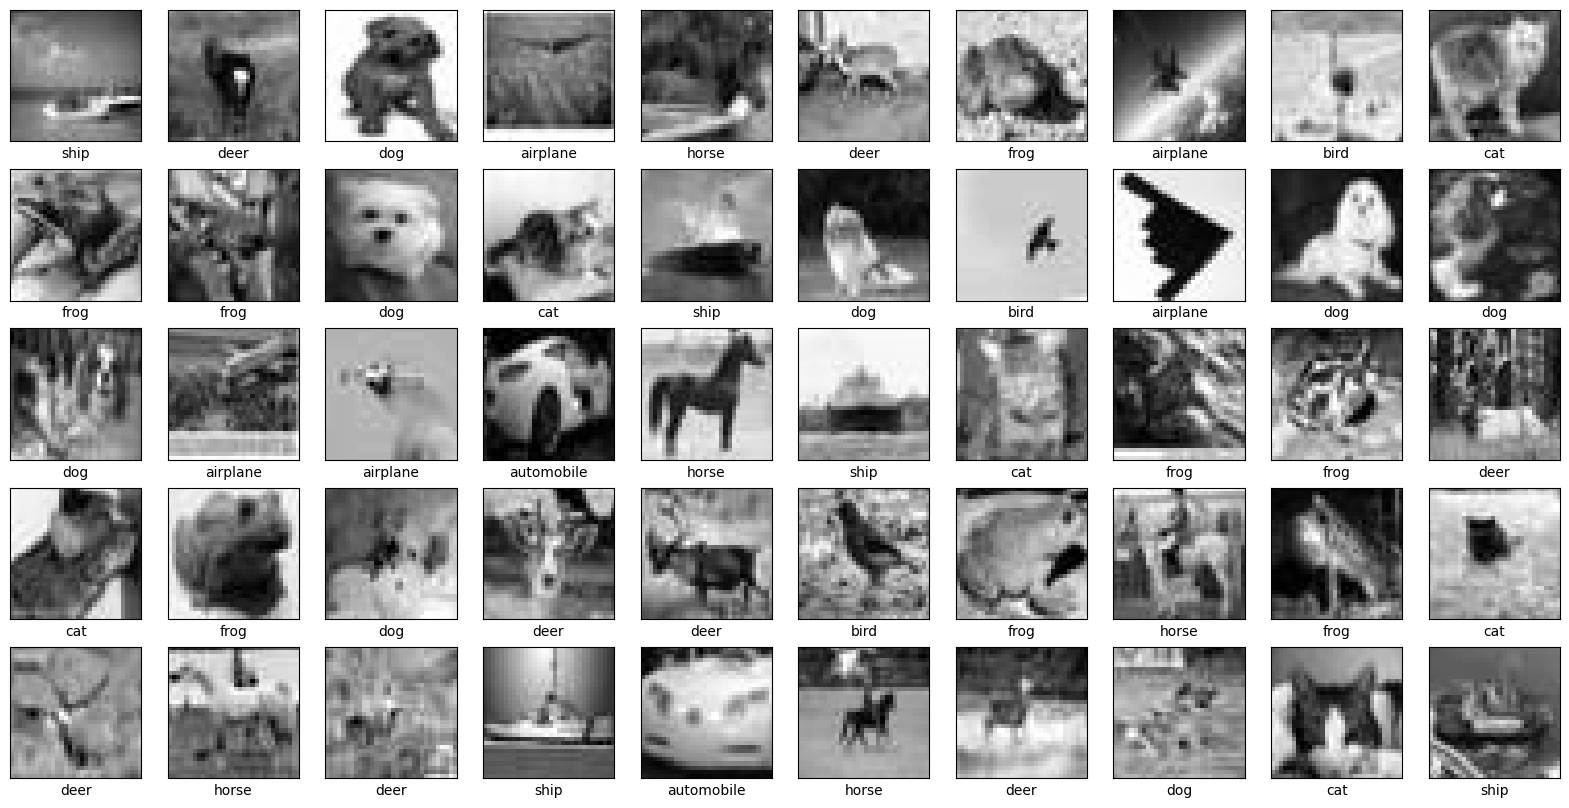

In [79]:

random.shuffle(TRAIN_DATA)

# Set the number of images to display
num_images = 50

plt.figure(figsize=(20, 10))

for i in range(num_images):
    plt.subplot(5, 10, i + 1)
    image = TRAIN_DATA[i][0]
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # Convert image to grayscale
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])

plt.show()

In [80]:
##K_fold cross
num_subsets = 5
subset_size = len(TRAIN_DATA) // num_subsets

subsets = [TRAIN_DATA[i * subset_size: (i + 1) * subset_size] for i in range(num_subsets)]

In [81]:
##define K-values
k_max = 15

def l1_dist(x, y):
    return np.sum(np.abs(x - y))

def l2_dist(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

In [83]:
# KNN classification
mean_accuracies_l1 = []
std_accuracies_l1 = []
mean_accuracies_l2 = []
std_accuracies_l2 = []

for class_idx, class_name in enumerate(CATEGORIES):
    class_fold_accuracies_l1 = []
    class_fold_accuracies_l2 = []

    for fold in tqdm(range(num_subsets), desc=f'Progress----> "{class_name}"'):
        fold_accuracies_l1 = []
        fold_accuracies_l2 = []

        train = [subset for i, subset in enumerate(subsets) if i != fold]  # Leave-one-out strategy
        validation = subsets[fold]

        acc_l1 = 0
        acc_l2 = 0

        for v in validation:
            l1_dists = []
            l2_dists = []

            for subset in train:
                for t in subset:
                    l1 = l1_dist(v[0], t[0])
                    l2 = l2_dist(v[0], t[0])
                    l1_dists.append((l1, t[1]))
                    l2_dists.append((l2, t[1]))

            l1_dists.sort(key=lambda x: x[0])
            l2_dists.sort(key=lambda x: x[0])

            neighbors_l1 = [d[1] for d in l1_dists[:k_max]]
            counts_l1 = np.bincount(neighbors_l1)
            pred_l1 = np.argmax(counts_l1)

            neighbors_l2 = [d[1] for d in l2_dists[:k_max]]
            counts_l2 = np.bincount(neighbors_l2)
            pred_l2 = np.argmax(counts_l2)

            if pred_l1 == v[1]:
                acc_l1 += 1
            if pred_l2 == v[1]:
                acc_l2 += 1

        fold_accuracies_l1.append(acc_l1 / len(validation))
        fold_accuracies_l2.append(acc_l2 / len(validation))

    mean_accuracies_l1.append(np.mean(fold_accuracies_l1))
    std_accuracies_l1.append(np.std(fold_accuracies_l1))
    mean_accuracies_l2.append(np.mean(fold_accuracies_l2))
    std_accuracies_l2.append(np.std(fold_accuracies_l2))

Progress----> "truck": 100%|██████████| 5/5 [21:51<00:00, 262.30s/it]


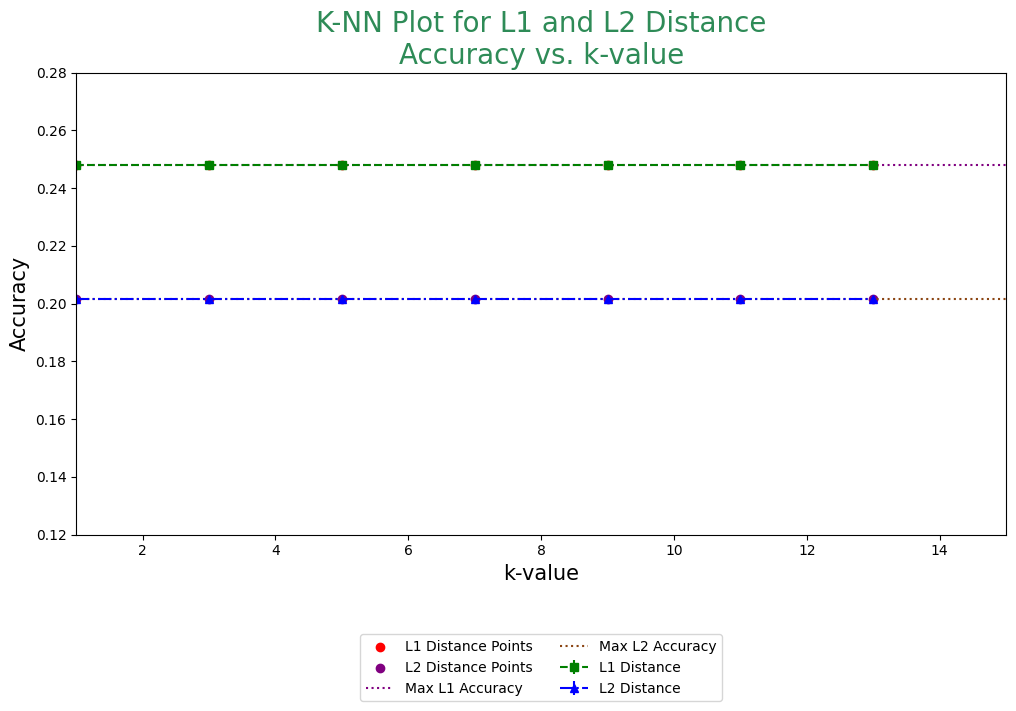

In [89]:
plt.figure(figsize=(12, 6))  ed

# Define the range based on k_max
k_range = range(1, k_max, 2)


mean_accuracies_l1 = mean_accuracies_l1[:len(k_range)]
mean_accuracies_l2 = mean_accuracies_l2[:len(k_range)]


std_accuracies_l1 = std_accuracies_l1[:len(k_range)]
std_accuracies_l2 = std_accuracies_l2[:len(k_range)]


plt.errorbar(k_range, mean_accuracies_l1, yerr=std_accuracies_l1, label="L1 Distance", color="green", linestyle="--", marker="s")
plt.errorbar(k_range, mean_accuracies_l2, yerr=std_accuracies_l2, label="L2 Distance", color="blue", linestyle="-.", marker="^")


plt.scatter(k_range, mean_accuracies_l1, color="red", marker="o", label="L1 Distance Points")
plt.scatter(k_range, mean_accuracies_l2, color="purple", marker="o", label="L2 Distance Points")

plt.xlabel("k-value", size=15)
plt.ylabel("Accuracy", size=15)
plt.title("K-NN Plot for L1 and L2 Distance\nAccuracy vs. k-value", size=20, color="seagreen")
plt.xlim(1, k_max)  # Set the x-axis limits
plt.ylim(0.12, 0.28)  # Set the y-axis limits

:
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

max_accuracy_l1 = max(mean_accuracies_l1)
max_accuracy_l2 = max(mean_accuracies_l2)
plt.axhline(y=max_accuracy_l1, linestyle='dotted', color='purple', label='Max L1 Accuracy')
plt.axhline(y=max_accuracy_l2, linestyle='dotted', color='saddlebrown', label='Max L2 Accuracy')

# Show the plot
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()

Top 5 Predictions for L1 Distance:
Prediction 1: Class 'cat' with L1 distance 0.00
Prediction 2: Class 'airplane' with L1 distance 851.83
Prediction 3: Class 'cat' with L1 distance 894.90
Prediction 4: Class 'airplane' with L1 distance 914.27
Prediction 5: Class 'truck' with L1 distance 927.74
Top Prediction Class (L1): cat

Top 5 Predictions for L2 Distance:
Prediction 1: Class 'cat' with L2 distance 0.00
Prediction 2: Class 'ship' with L2 distance 298.42
Prediction 3: Class 'dog' with L2 distance 299.89
Prediction 4: Class 'deer' with L2 distance 300.84
Prediction 5: Class 'ship' with L2 distance 302.44
Top Prediction Class (L2): cat



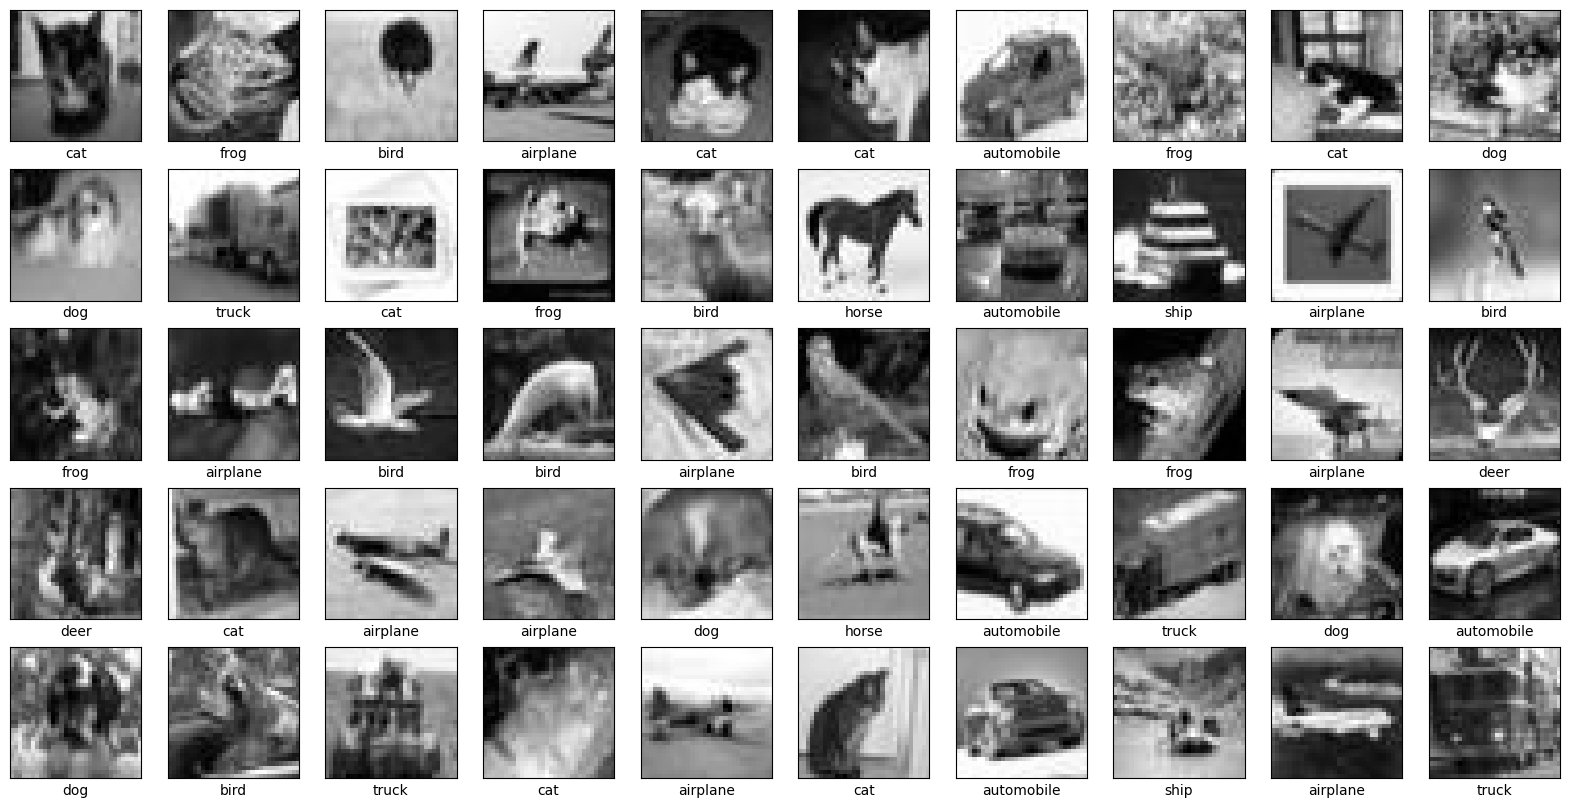

In [94]:
##display top 5 prediction

random.shuffle(TRAIN_DATA)

# Create a figure to display images
plt.figure(figsize=(20, 10))

for i in range(50):
    plt.subplot(5, 10, i+1)
    image = TRAIN_DATA[i][0]
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # Convert image to grayscale
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 49:
        break

# Initialize an empty list to store the test images
test_images = []

for i in range(2000):
    test_image = TRAIN_DATA[i][0]
    test_image_gray = cv.cvtColor(test_image, cv.COLOR_BGR2GRAY)  # Convert test image to grayscale
    test_images.append(test_image_gray)

# Display top 5 Predictions for both L1 and L2 Distances
for test_image_gray in test_images:
    distances1 = []
    distances2 = []

    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv.cvtColor(train_image, cv.COLOR_BGR2GRAY)
        dist1 = l1_dist(test_image_gray, train_image_gray)
        dist2 = l2_dist(test_image_gray, train_image_gray)
        distances1.append((dist1, class_num))
        distances2.append((dist2, class_num))

    distances1.sort(key=lambda x: x[0])
    distances2.sort(key=lambda x: x[0])

    top_5_predictions1 = distances1[:5]
    top_5_predictions2 = distances2[:5]

    print("Top 5 Predictions for L1 Distance:")
    for i, (dist1, class_num) in enumerate(top_5_predictions1):
        predicted_class = CATEGORIES[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L1 distance {dist1/100:.2f}")

    # Display the image of the test_data and corresponding class of the top prediction for L1
    top_prediction_class_num = top_5_predictions1[0][1]
    top_prediction_class = CATEGORIES[top_prediction_class_num]
    print(f"Top Prediction Class (L1): {top_prediction_class}\n")

    print("Top 5 Predictions for L2 Distance:")
    for i, (dist2, class_num) in enumerate(top_5_predictions2):
        predicted_class = CATEGORIES[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L2 distance {dist2:.2f}")

    # Display the image of the test_data and corresponding class of the top prediction for L2
    top_prediction_class_num = top_5_predictions2[0][1]
    top_prediction_class = CATEGORIES[top_prediction_class_num]
    print(f"Top Prediction Class (L2): {top_prediction_class}\n")
    break  


Discussion :

In this assignment, we have implemented a k-nearest neighbors(KNN) classifier using two different distance metrics: Manhattan(L1) and Euclidean(L2) distancecs and then conducted a 5-fold cross-validation to evaluate the performance of these distance metrics.

The assignment computes and compares the average accuracy for both L1 and L2 distances over different k values. the results are visualized in a plot which shows that the accuracy remains relatively flat for both metrics across different k values. The L1 distance appears to have a slightly better accuracy compared to the L2 distance for the given dataset, but the difference is not substantial. Both metrics have similar trends in accuracy as K increases. The choice of k can significantly impact the performance. 
The dataset used in the analysis is CIFAR-10 dataset consisting of 10,000 32x32x3 color images in 10 different classes, however we have converted the image to greyscale for our analysis. The choice of greyscale simplifies the dataset, but it may result in a loss of information compared to using the full-color images.
The performance of the KNN can be affected by the complexity of classes.Some classes may be easier to distinguish due to distinct features, while others may share similarities that are challenging to differentiate using KNN alone. The choice of distance metric plays a crucial role in handling such similarities.
The flatness of the accuracy curve suggests that KNN with these distance metrics might not be the most suitable approach for this dataset. More advanced machine learning algorithms like convolutional neural networks (CNNs) can be explored to achieve better results on image classification tasks.
Data preprocessing techniques, such as feature scaling, dimensionality reduction, or data augmentation, can be applied to improve KNN performance.
A hyperparameter search to find the optimal k value for each distance metric may yield better results.
Other distance metrics, such as cosine similarity, can also be considered, as they might perform differently on this dataset.
It's important to ensure that the dataset is balanced to avoid class imbalance issues.
In conclusion, while KNN is a simple and interpretable algorithm, its performance is highly dependent on the choice of distance metric and the dataset's characteristics. The choice between L1 and L2 distance depends on the specific dataset and problem at hand. In this case, L1 distance appears to perform slightly better, but overall, more advanced machine learning techniques and preprocessing methods may be necessary to achieve higher accuracy on this grayscale image dataset.